In [1]:
import pandas as pd
import numpy as np
import itertools
from collections import defaultdict
from datetime import datetime
import os

# display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# custom helper functions
%load_ext autoreload
%autoreload 2
from helper.keras_class import *

# show images
from PIL import Image
import requests

# keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
from keras.layers import Concatenate, Dense, Dropout
from keras.layers import Add, Activation, Lambda, Input, Embedding
from keras.models import Model
from keras.layers import Input, Reshape, Dot, Dense
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2


# sklearn
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer

# view plotly in jupyter 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

%load_ext tensorboard
import tensorboard
from tensorboard.plugins import projector

In [2]:
df = pd.read_csv('../../merged_df.csv')

In [3]:
df = df[df['title'].notna()]

# select reviewer and product values
customers = df['reviewerID'].value_counts()
products = df['asin'].value_counts()

# filter by 10 reviews per product per customer, products with 20 or more reviews
customers = customers[customers >= 10]
products = products[products >= 20]

# merge dataframe
df = df.merge(pd.DataFrame({'reviewerID': customers.index})).merge(pd.DataFrame({'asin': products.index}))


# shuffle dataframe
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df = df[['reviewerID', 'asin', 'overall']]


In [4]:
# get a list of unique users
user_ids = df['reviewerID'].unique().tolist()
product_ids = df['asin'].unique().tolist()

# encode users and products as numberical
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

product2product_encoded = {x: i for i, x in enumerate(product_ids)}
product_encoded2product = {i: x for i, x in enumerate(product_ids)}


# remap numerical
df['user'] = df['reviewerID'].map(user2user_encoded)
df['product'] = df['asin'].map(product2product_encoded)

# set number of users and products
num_users = len(user2user_encoded)
num_products = len(product_encoded2product)

# ensure correct value format
df['overall'] = df['overall'].values.astype(np.float32)

# set min and max ratings
min_rating = min(df['overall'])
max_rating = max(df['overall'])


In [5]:
print(
    "Number of users: {}, Number of Products: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_products, min_rating, max_rating
    )
)

Number of users: 8665, Number of Products: 4342, Min rating: 1.0, Max rating: 5.0


In [6]:
# set and normalize ratings
x = df[['user', 'product']].values
y = df['overall'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# train test split
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:])

#### first model

In [7]:
# create keras model
embedding_size = 50

model = RecommenderNet(num_users, num_products, embedding_size)
# model.compile(
#     loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
# )

model.compile(
    loss=tf.keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(lr=0.001)
)


In [ ]:
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [8]:
# train model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_data=(x_val, y_val))

Epoch 1/10
1588/1588 [==============================] - 8s 4ms/step - loss: 0.1334 - val_loss: 0.0722
Epoch 2/10
1588/1588 [==============================] - 5s 3ms/step - loss: 0.0679 - val_loss: 0.0757
Epoch 3/10
1588/1588 [==============================] - 5s 3ms/step - loss: 0.0633 - val_loss: 0.0738
Epoch 4/10
1588/1588 [==============================] - 5s 3ms/step - loss: 0.0619 - val_loss: 0.0739
Epoch 5/10
1588/1588 [==============================] - 5s 3ms/step - loss: 0.0618 - val_loss: 0.0753
Epoch 6/10
1588/1588 [==============================] - 5s 3ms/step - loss: 0.0620 - val_loss: 0.0752
Epoch 7/10
1588/1588 [==============================] - 5s 3ms/step - loss: 0.0633 - val_loss: 0.0731
Epoch 8/10
1588/1588 [==============================] - 5s 3ms/step - loss: 0.0648 - val_loss: 0.0717
Epoch 9/10
1588/1588 [==============================] - 5s 3ms/step - loss: 0.0654 - val_loss: 0.0695
Epoch 10/10
1588/1588 [==============================] - 5s 3ms/step - loss: 0.067

In [ ]:
%tensorboard --logdir logs

In [17]:
model.summary()

Model: "recommender_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  433250    
_________________________________________________________________
embedding_1 (Embedding)      multiple                  8665      
_________________________________________________________________
embedding_2 (Embedding)      multiple                  217100    
_________________________________________________________________
embedding_3 (Embedding)      multiple                  4342      
Total params: 663,357
Trainable params: 663,357
Non-trainable params: 0
_________________________________________________________________


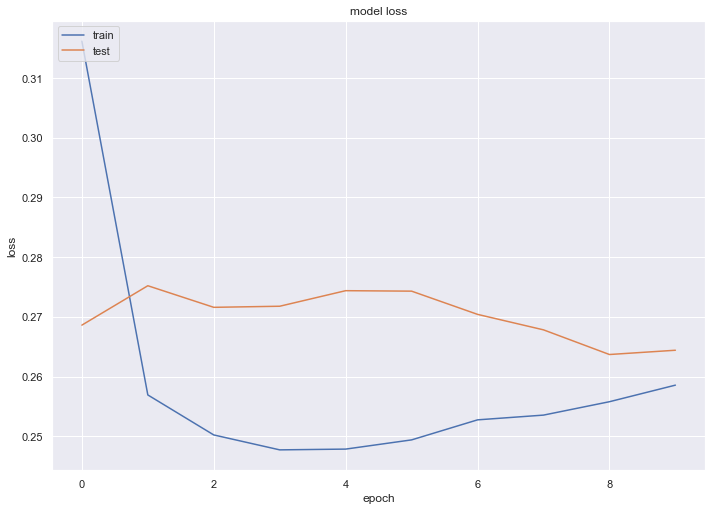

In [19]:
plt.plot(np.sqrt(history.history["loss"]))
plt.plot(np.sqrt(history.history["val_loss"]))
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()
# plt.savefig(r"../images/keras_error.png");

##### Second Model

In [28]:
model = ModRecommenderNet(num_users, num_products, n_factors=50, min_rating=1, max_rating=5)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 50)        433250      input_6[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 50)        217100      input_7[0][0]                    
____________________________________________________________________________________________

In [29]:
X = df[['user', 'product']].values
y = df['overall'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

((101619, 2), (11291, 2), (101619,), (11291,))

In [30]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [33]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=10,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/10
1588/1588 [==============================] - 6s 4ms/step - loss: 0.7339 - val_loss: 1.0119
Epoch 2/10
1588/1588 [==============================] - 6s 4ms/step - loss: 0.7187 - val_loss: 1.0221
Epoch 3/10
1588/1588 [==============================] - 6s 4ms/step - loss: 0.7108 - val_loss: 1.0277
Epoch 4/10
1588/1588 [==============================] - 6s 4ms/step - loss: 0.6971 - val_loss: 1.0590
Epoch 5/10
1588/1588 [==============================] - 6s 4ms/step - loss: 0.6898 - val_loss: 1.0552
Epoch 6/10
1588/1588 [==============================] - 6s 4ms/step - loss: 0.6863 - val_loss: 1.0460
Epoch 7/10
1588/1588 [==============================] - 6s 4ms/step - loss: 0.6769 - val_loss: 1.0735
Epoch 8/10
1588/1588 [==============================] - 6s 4ms/step - loss: 0.6716 - val_loss: 1.0806
Epoch 9/10
1588/1588 [==============================] - 6s 4ms/step - loss: 0.6680 - val_loss: 1.1004
Epoch 10/10
1588/1588 [==============================] - 6s 4ms/step - loss: 0.664

Text(0, 0.5, 'Error')

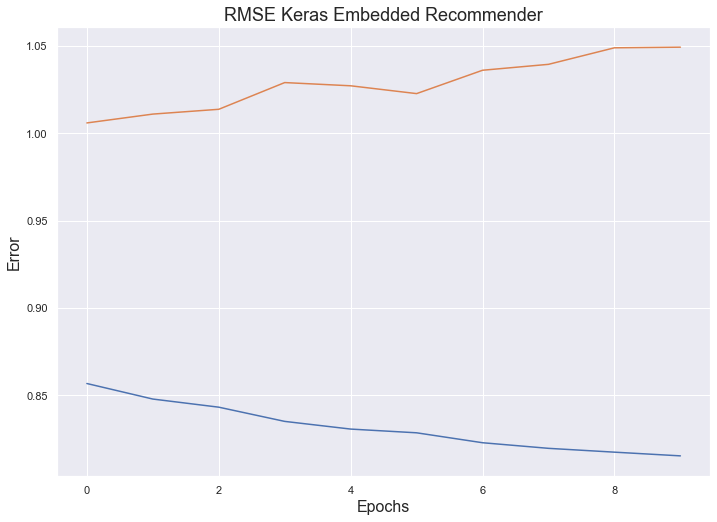

In [34]:
figure = sns.lineplot(data = np.sqrt(history.history["loss"]))
figure = sns.lineplot(data = np.sqrt(history.history["val_loss"]))
# plt.axvline(np.median(error),color='r', linestyle='--')
plt.title('RMSE Keras Embedded Recommender', fontsize=18)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Error', fontsize=16)
# plt.savefig(r"../images/keras_error");

In [ ]:
# model.save_weights('model_weights', save_format='tf')

In [ ]:
# pd.DataFrame(x_train).to_csv("../../x_train.csv", index=False)

In [ ]:
# pd.DataFrame(y_train).to_csv("../../y_train.csv", index=False)

In [5]:
x_train = pd.read_csv('../../x_train.csv').to_numpy()
y_train = pd.read_csv('../../y_train.csv').to_numpy()

In [6]:
loaded_model = RecommenderNet(num_users=8665, num_products=4342, embedding_size=50)
loaded_model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(lr=0.001))
loaded_model.train_on_batch(x_train[:1], y_train[:1])
loaded_model.load_weights('../models/model_weights')

In [7]:
model = loaded_model

In [8]:
model.summary()

Model: "recommender_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  433250    
_________________________________________________________________
embedding_1 (Embedding)      multiple                  8665      
_________________________________________________________________
embedding_2 (Embedding)      multiple                  217100    
_________________________________________________________________
embedding_3 (Embedding)      multiple                  4342      
Total params: 663,357
Trainable params: 663,357
Non-trainable params: 0
_________________________________________________________________


In [15]:
original_df = pd.read_csv('../../merged_df.csv')

Showing recommendations for user: A2E3NAL9ECE7VS
Products with high ratings from user
--------------------------------


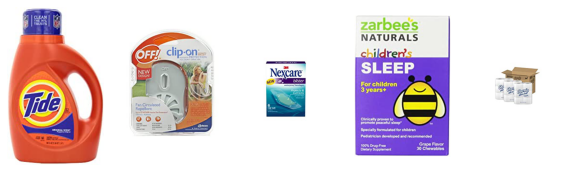

In [19]:
# Let us get a user and see the top recommendations.
user_id = df.reviewerID.sample(1).iloc[0]

products_bought_by_user = df[df.reviewerID == user_id]
x = df[df.user == user_id]['product'].values
products_not_bought = df[~df['asin'].isin(x)]['asin'].unique()


products_not_bought = list(
    set(products_not_bought).intersection(set(product2product_encoded.keys()))
)

products_not_bought = [[product2product_encoded.get(x)] for x in products_not_bought]

user_encoder = user2user_encoded.get(user_id)
user_product_array = np.hstack(
    ([[user_encoder]] * len(products_not_bought), products_not_bought)
)

ratings = model.predict(user_product_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]

recommended_product_ids = [
    product_encoded2product.get(products_not_bought[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Products with high ratings from user")
print("----" * 8)

top_products_user = (
    products_bought_by_user.sort_values(by="overall", ascending=False)
    .head(5)
    .asin.values
)

original_df_rows = original_df[original_df["asin"].isin(top_products_user)][['asin', 'title', 'imUrl']].drop_duplicates()
im_list = []
for idx, row in enumerate(original_df_rows.itertuples()):
    url = row.imUrl
    idx = Image.open(requests.get(url, stream=True).raw)
    im_list.append([idx, row.title])

fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 1
columns = 5
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(im_list[0][0])
plt.axis('off')
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(im_list[1][0])
plt.axis('off')
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(im_list[2][0])
plt.axis('off')
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(im_list[3][0])
plt.axis('off')

fig.add_subplot(rows, columns, 5)

plt.imshow(im_list[4][0])
plt.axis('off');

--------------------------------
Top product recommendations
--------------------------------


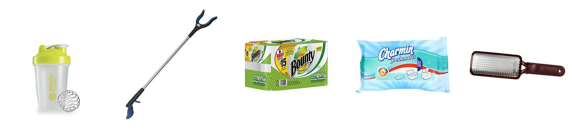

In [20]:
print("----" * 8)
print("Top product recommendations")
print("----" * 8)

recommended_products = original_df[original_df["asin"].isin(recommended_product_ids)][['asin', 'title', 'imUrl']].drop_duplicates()
im_list = []
for row in recommended_products.itertuples():
    url = row.imUrl
    idx = Image.open(requests.get(url, stream=True).raw)
    im_list.append([idx, row.title])
    
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 1
columns = 5
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(im_list[0][0])
plt.axis('off')
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(im_list[1][0])
plt.axis('off')
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(im_list[2][0])
plt.axis('off')
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(im_list[3][0])
plt.axis('off')

fig.add_subplot(rows, columns, 5)

plt.imshow(im_list[4][0])
plt.axis('off'); 